In [46]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

In [47]:
!pip install --upgrade numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.25.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.0 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.0 which is incompatible.


In [48]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar xvzf ta-lib-0.4.0-src.tar.gz
import os
os.chdir('ta-lib') # Can't use !cd in co-lab
!./configure --prefix=/usr
!make
!make install
os.chdir('../')
!pip install TA-Lib
import talib

--2023-06-26 18:34:16--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-06-26 18:34:16--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://cytranet.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-06-26 18:34:16--  http://cytranet.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving cytranet.dl.s

2.Data Loading

In [49]:
# load dataset
dataset = pd.read_csv('AAPL-4.csv')

In [50]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

3. Exploratory Data Analysis

In [51]:
# Shape
dataset.shape

(2768, 7)

In [52]:
# peak at data
set_option('display.width', 100)
dataset.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume
2763,2022-12-23,130.919998,132.419998,129.639999,131.860001,131.477127,63814900
2764,2022-12-27,131.380005,131.410004,128.720001,130.029999,129.652435,69007800
2765,2022-12-28,129.669998,131.029999,125.870003,126.040001,125.674019,85438400
2766,2022-12-29,127.989998,130.479996,127.730003,129.610001,129.233658,75703700
2767,2022-12-30,128.410004,129.949997,127.430000,129.929993,129.552719,77034200


In [53]:
# describe data
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2.768000e+03
mean,58.609123,59.266503,57.962710,58.637391,56.583387,2.035526e+08
std,47.957848,48.585227,47.342160,47.986391,48.428995,1.717732e+08
min,13.856071,14.271429,13.753571,13.947500,12.029552,3.519590e+07
25%,24.148750,24.371519,23.916697,24.163751,21.891779,9.501720e+07
50%,37.632500,38.088751,37.301250,37.661249,35.725656,1.395220e+08
75%,77.147501,78.218752,76.302502,77.390627,75.656924,2.480580e+08
max,182.630005,182.940002,179.119995,182.009995,180.434296,1.506120e+09


4.Data Prepare

In [54]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


In [55]:
dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()

In [56]:
dataset=dataset.drop(columns=['Date'])

 4.1 Preparing the data for classification

 We attach a label to each movement:

1 if the signal is that short term price will go up as compared to the long term.

0 if the signal is that short term price will go down as compared to the long term.

In [57]:
# Initialize the `signals` DataFrame with the `signal` column
#datas['PriceMove'] = 0.0

# Create short simple moving average over the short window
#dataset['short_mavg'] = dataset['Adj Close'].rolling(window=10, min_periods=1, center=False).mean()
dataset['short_mavg'] = talib.SMA(dataset['Adj Close'], timeperiod=10)
# Create long simple moving average over the long window
#dataset['long_mavg'] = dataset['Adj Close'].rolling(window=60, min_periods=1, center=False).mean()
dataset['long_mavg'] = talib.SMA(dataset['Adj Close'], timeperiod=60)
# Create signals
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)

In [58]:
dataset.tail()

,Open,High,Low,Close,Adj Close,Volume,short_mavg,long_mavg,signal
2763,130.919998,132.419998,129.639999,131.860001,131.477127,63814900,136.441666,143.249474,0.0
2764,131.380005,131.410004,128.720001,130.029999,129.652435,69007800,134.999864,143.117506,0.0
2765,129.669998,131.029999,125.870003,126.040001,125.674019,85438400,133.062505,142.848721,0.0
2766,127.989998,130.479996,127.730003,129.610001,129.233658,75703700,131.706454,142.578707,0.0
2767,128.410004,129.949997,127.430000,129.929993,129.552719,77034200,131.051360,142.309033,0.0


4.2 Feature Engineering

In [59]:
#!pip install --upgrade numpy

In [60]:
#EMA
dataset['EMA10'] = talib.EMA(dataset['Adj Close'],timeperiod=10)
dataset['EMA30'] = talib.EMA(dataset['Adj Close'],timeperiod=30)
dataset['EMA200'] = talib.EMA(dataset['Adj Close'],timeperiod=200)

#ROC
dataset['ROC10'] = talib.ROC(dataset['Adj Close'],timeperiod=10)
dataset['ROC30'] = talib.ROC(dataset['Adj Close'],timeperiod=30)

#MOM
dataset['MOM10'] = talib.MOM(dataset['Adj Close'], timeperiod=10)
dataset['MOM30'] = talib.MOM(dataset['Adj Close'], timeperiod=30)

#RSI
dataset['RSI10'] = talib.RSI(dataset['Adj Close'],timeperiod=10)
dataset['RSI30'] = talib.RSI(dataset['Adj Close'],timeperiod=30)
dataset['RSI200'] = talib.RSI(dataset['Adj Close'],timeperiod=200)

##Stochastic osillator
# STOK. STOD
def STOK(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)
#MA
dataset['MA21'] = talib.MA(dataset['Adj Close'], timeperiod=21)
dataset['MA63'] = talib.MA(dataset['Adj Close'], timeperiod=63)
dataset['MA252'] = talib.MA(dataset['Adj Close'], timeperiod=252)


In [61]:
dataset.tail()

,Open,High,Low,Close,Adj Close,Volume,short_mavg,long_mavg,signal,EMA10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
2763,130.919998,132.419998,129.639999,131.860001,131.477127,63814900,136.441666,143.249474,0.0,135.538389,...,48.578593,10.919832,16.754144,9.269321,14.200879,5.576444,8.186681,140.606253,143.444852,154.802602
2764,131.380005,131.410004,128.720001,130.029999,129.652435,69007800,134.999864,143.117506,0.0,134.468216,...,48.389798,6.164696,9.579300,5.267383,8.136703,2.574176,4.819571,139.747800,143.104910,154.607695
2765,129.669998,131.029999,125.870003,126.040001,125.674019,85438400,133.062505,142.848721,0.0,132.869271,...,47.981183,0.817691,5.967406,0.613269,5.049991,0.316334,2.822318,138.884599,142.732157,154.401093
2766,127.989998,130.479996,127.730003,129.610001,129.233658,75703700,131.706454,142.578707,0.0,132.208250,...,48.373203,23.477702,10.153363,13.939615,6.606756,6.959431,3.283314,138.335721,142.532199,154.208262
2767,128.410004,129.949997,127.430000,129.929993,129.552719,77034200,131.051360,142.309033,0.0,131.725426,...,48.408228,34.465137,19.586843,15.132281,9.895055,7.554876,4.943547,137.476319,142.404933,154.021339


In [62]:
#excluding columns that are not needed for our prediction.

dataset=dataset.drop(['High','Low','Open','Close','short_mavg','long_mavg'], axis=1)

In [63]:
dataset = dataset.dropna(axis=0)

In [64]:
dataset.tail()

,Adj Close,Volume,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
2763,131.477127,63814900,0.0,135.538389,140.654381,149.097294,-7.245350,-10.219912,-10.270081,-14.966400,...,48.578593,10.919832,16.754144,9.269321,14.200879,5.576444,8.186681,140.606253,143.444852,154.802602
2764,129.652435,69007800,0.0,134.468216,139.944578,148.903813,-10.007614,-13.139613,-14.418015,-19.612885,...,48.389798,6.164696,9.579300,5.267383,8.136703,2.574176,4.819571,139.747800,143.104910,154.607695
2765,125.674019,85438400,0.0,132.869271,139.023896,148.672671,-13.356710,-14.998652,-19.373588,-22.175423,...,47.981183,0.817691,5.967406,0.613269,5.049991,0.316334,2.822318,138.884599,142.732157,154.401093
2766,129.233658,75703700,0.0,132.208250,138.392268,148.479248,-9.496547,-13.616362,-13.560516,-20.370666,...,48.373203,23.477702,10.153363,13.939615,6.606756,6.959431,3.283314,138.335721,142.532199,154.208262
2767,129.552719,77034200,0.0,131.725426,137.821975,148.290924,-4.813195,-12.675584,-6.550934,-18.805237,...,48.408228,34.465137,19.586843,15.132281,9.895055,7.554876,4.943547,137.476319,142.404933,154.021339


4.3 data visualize

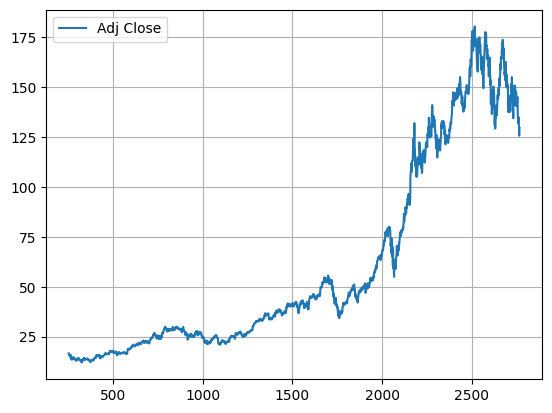

In [65]:
dataset[['Adj Close']].plot(grid=True)
plt.show()

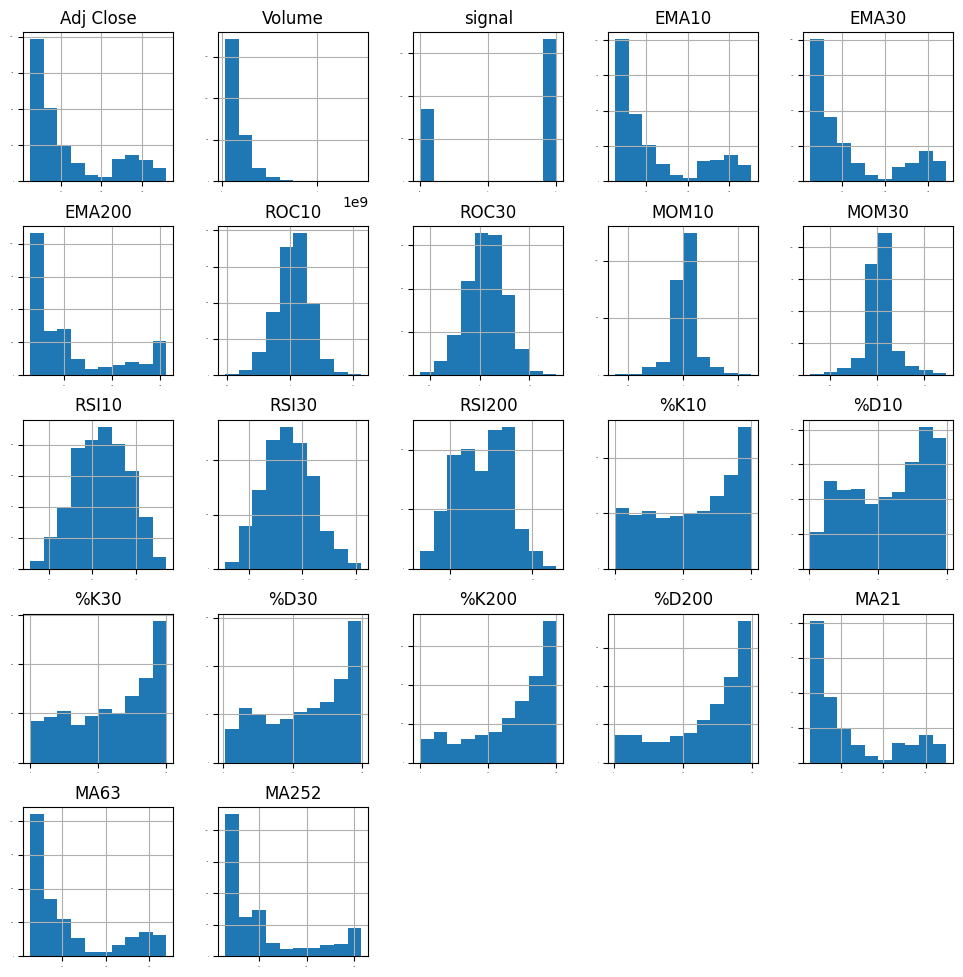

In [66]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

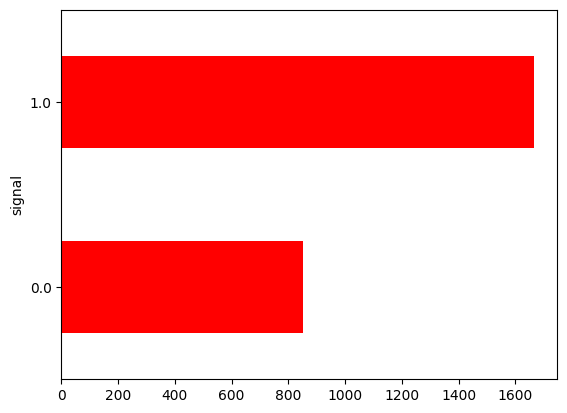

In [67]:
fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

<Axes: title={'center': 'Correlation Matrix'}>

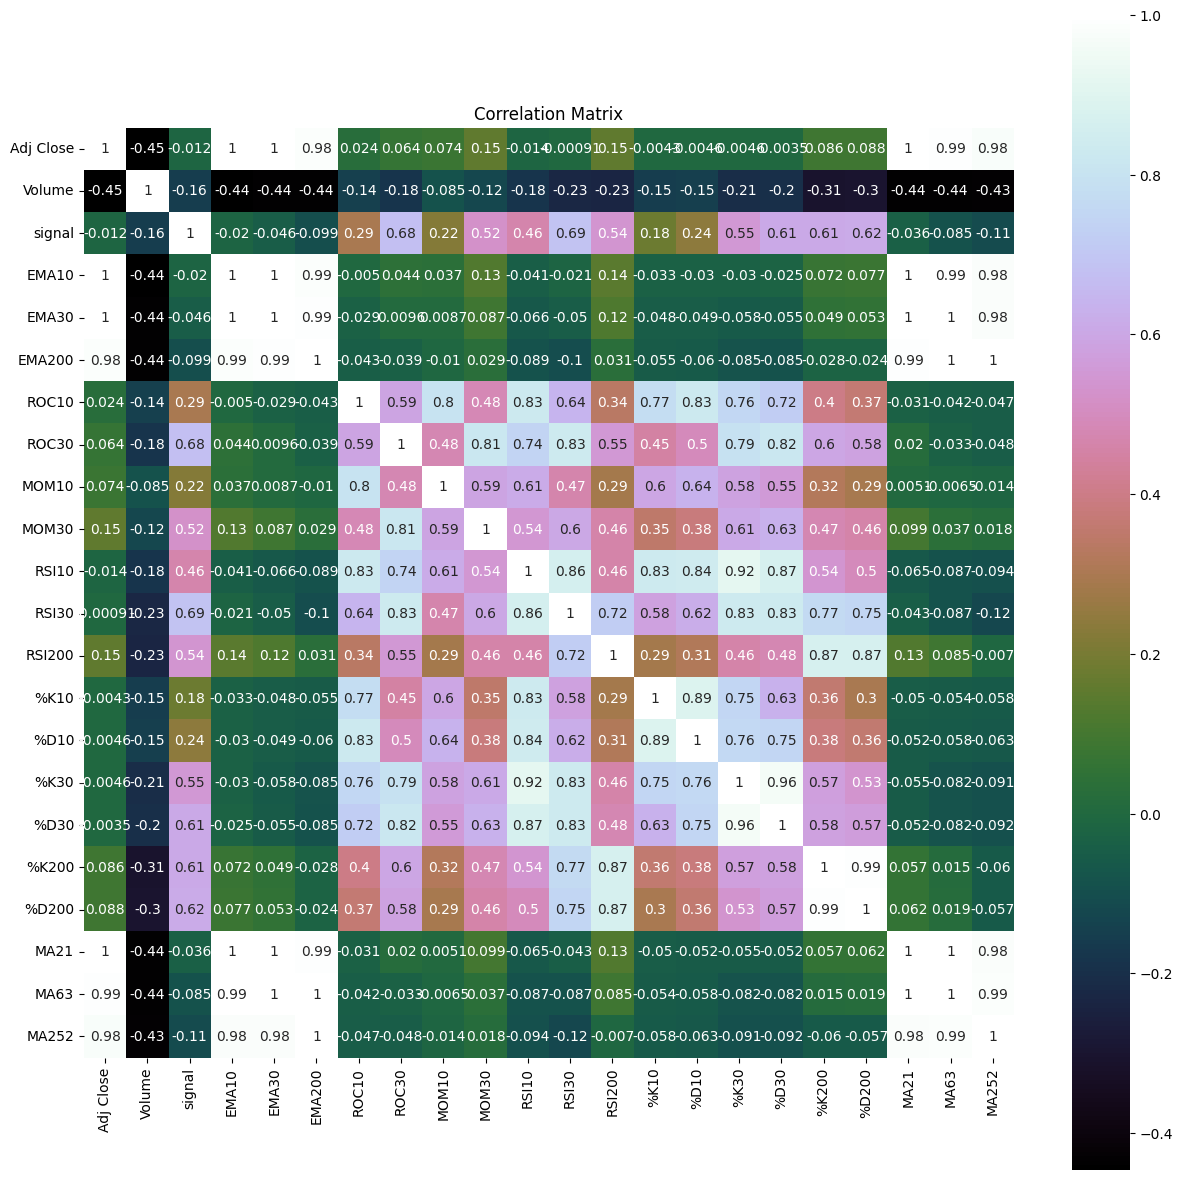

In [68]:
# correlation
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

# 5. Evaluate Algorithms and Models

  5.1 Train Split Data
  We split the dataset into 80% training set and 20% test set.

In [69]:
# split out validation dataset for the end
subset_dataset= dataset.iloc[-100000:]
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

5.2. Test Options and Evaluation Metrics

In [70]:
# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

5.3. Compare Models and Algorithms

In order to know which algorithm technic is the best for our strategy, we evaluate following non linear different methods:

5.3.1 Models

In [71]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

K-folds cross validation

In [72]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=None, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.656231 (0.028564)
LDA: 0.919534 (0.018903)
KNN: 0.603071 (0.035755)
CART: 0.901133 (0.017200)
NB: 0.665196 (0.030370)
NN: 0.411428 (0.135734)
AB: 0.934932 (0.015888)
GBM: 0.941877 (0.013344)
RF: 0.948328 (0.013748)


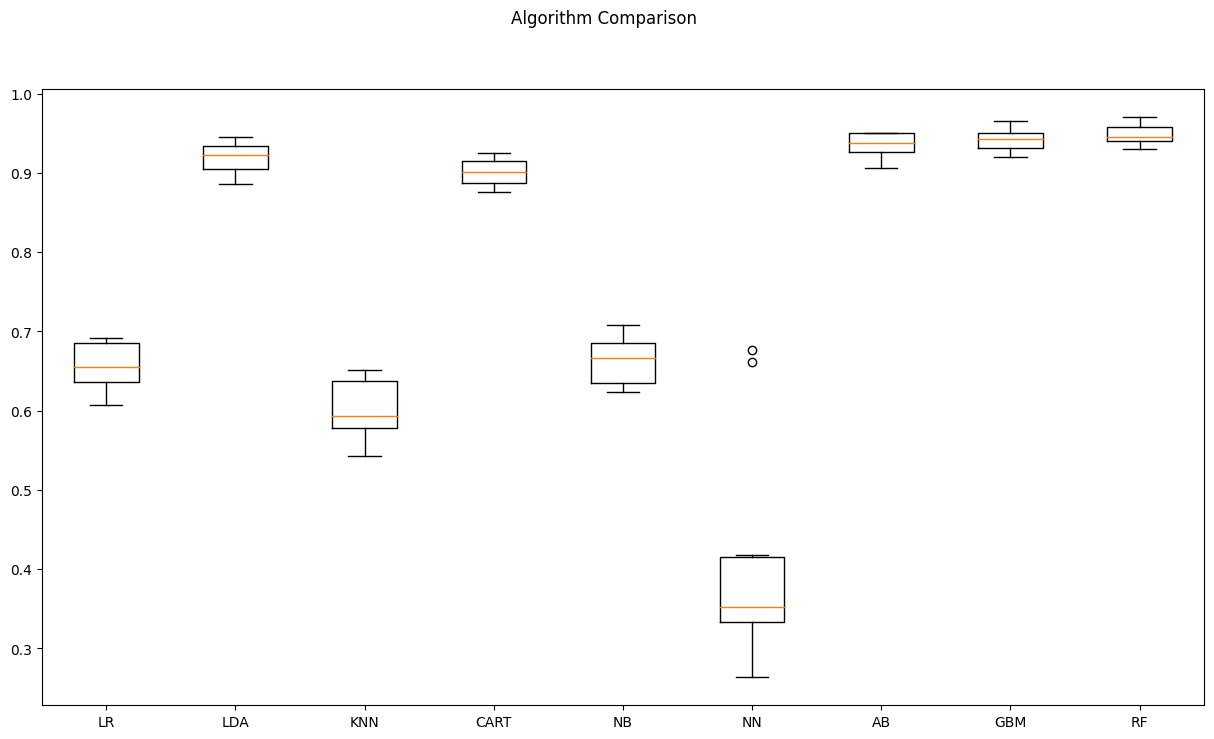

In [73]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

6. Model Tuning and Grid Search

Random forest is selected for the grid search as it is one of the best models out of all.

In [74]:
# Grid Search: Random Forest Classifier
'''
n_estimators : int (default=100)
    The number of boosting stages to perform.
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators.
    The maximum depth limits the number of nodes in the tree.
    Tune this parameter for best performance; the best value depends on the interaction of the input variables
criterion : string, optional (default=”gini”)
    The function to measure the quality of a split.
    Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

'''
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds, random_state=None, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.946335 using {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}
#7 0.919024 (0.015268) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#6 0.920509 (0.017266) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#3 0.944845 (0.014367) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#2 0.944848 (0.014357) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#8 0.915546 (0.014434) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#5 0.921504 (0.016782) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#4 0.943857 (0.013386) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#1 0.946335 (0.013536) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


7. Finalize Models

Finalizing the model with best parameters found during tuning step.

7.1 Results on the Test Dataset

In [75]:
# prepare model
model = RandomForestClassifier(criterion='gini', n_estimators=80,max_depth=10,n_jobs=-1) # rbf is default kernel
#model = LogisticRegression()
model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=80, n_jobs=-1)

In [76]:
# estimate accuracy on validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9484126984126984
[[142  19]
 [  7 336]]
              precision    recall  f1-score   support

         0.0       0.95      0.88      0.92       161
         1.0       0.95      0.98      0.96       343

    accuracy                           0.95       504
   macro avg       0.95      0.93      0.94       504
weighted avg       0.95      0.95      0.95       504



<Axes: xlabel='Predicted', ylabel='Actual'>

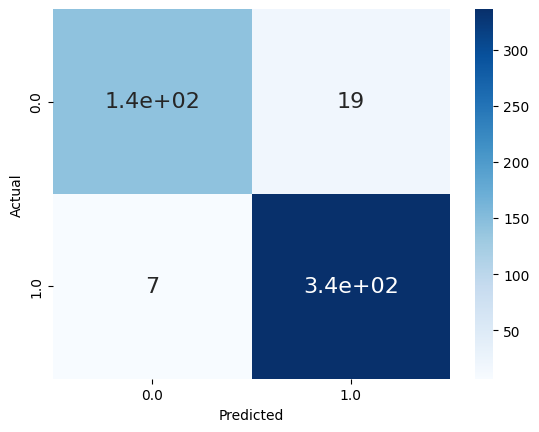

In [77]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

7.2. Variable Intuition/Feature Importance

Let us look into the Feature Importance of the model

Text(0.5, 0, 'Variable Importance')

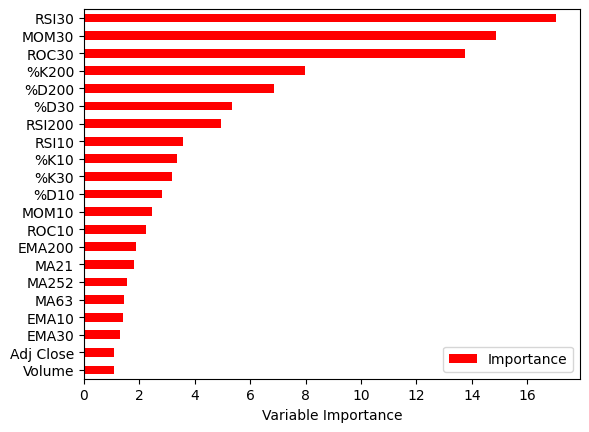

In [78]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

8.Backtesting Results

<Axes: >

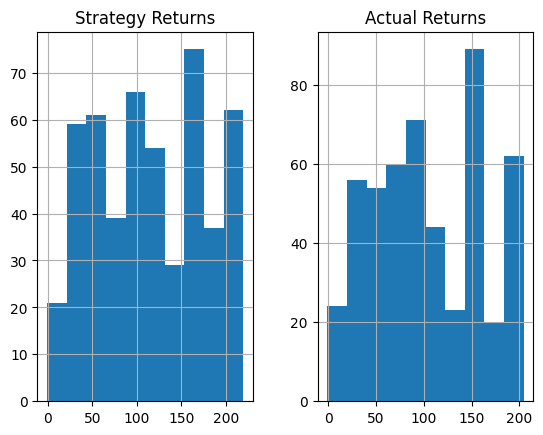

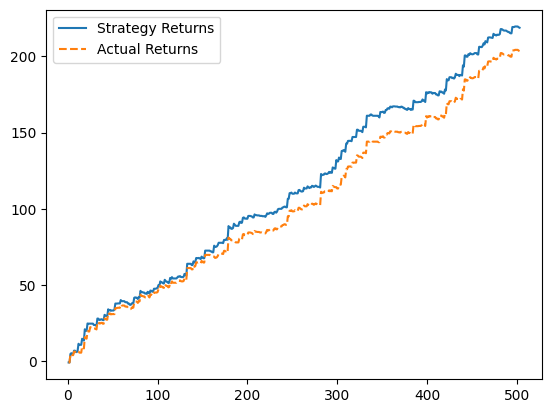

In [79]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata = pd.DataFrame(index=X_validation.index)
#backtestdata = pd.DataFrame()
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_validation
backtestdata['Market Returns'] = X_validation['Adj Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot(style=['-','--'])

In [80]:
backtestdata.head()

,index,signal_pred,signal_actual,Market Returns,Actual Returns,Strategy Returns
0,2339,1.0,1.0,NaN,NaN,NaN
1,1762,0.0,0.0,-0.729216,-0.729216,-0.729216
2,479,1.0,1.0,-0.519493,-0.000000,-0.000000
3,2225,1.0,0.0,5.596410,5.596410,5.596410
4,2548,1.0,1.0,0.514875,0.000000,0.514875


In [81]:
backtestdata.tail()

,index,signal_pred,signal_actual,Market Returns,Actual Returns,Strategy Returns
499,2401,1.0,1.0,5.164878,0.000000,0.000000
500,2626,0.0,0.0,-0.018440,-0.018440,-0.018440
501,1815,1.0,1.0,-0.674438,-0.000000,-0.000000
502,691,1.0,1.0,-0.516511,-0.516511,-0.516511
503,467,1.0,1.0,-0.269904,-0.269904,-0.269904


In [87]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [88]:
import shap

SystemError: ignored

In [ ]:
#X_frame = pd.DataFrame(data=X_validation)

In [ ]:
explainer = shap.Explainer(model, X_validation)


In [ ]:
shap_values = explainer(X_validation)

In [ ]:
#class_probabilities = model.predict_proba(X_train)
#A = np.mean(class_probabilities, axis=0)


In [ ]:
shap.plots.waterfall(shap_values[0])
